In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow import keras

2024-04-20 13:32:14.783041: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-20 13:32:14.783112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-20 13:32:14.783830: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-20 13:32:14.789589: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-20 13:32:15.446178: W tensorflow/compiler/tf2

In [18]:
IMAGE_SIZE=256
BATCH_SIZE=64
EPOCHS=30
CHANNELS=3

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    'Tomatos_Images',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
dataset

Found 16011 files belonging to 10 classes.


2024-04-18 22:32:01.959910: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-18 22:32:02.254658: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-18 22:32:02.255018: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [4]:
class_names=dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
len(class_names)

10

In [6]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(64, 256, 256, 3)
[6 2 2 5 2 2 2 0 5 7 9 0 9 7 9 2 4 4 4 4 6 7 5 9 7 7 0 6 2 4 4 8 7 6 7 5 1
 4 1 9 5 9 4 6 2 1 5 2 0 5 2 9 3 1 2 1 3 7 5 9 7 5 0 2]


In [7]:
len(dataset)

251

VISUALIZE

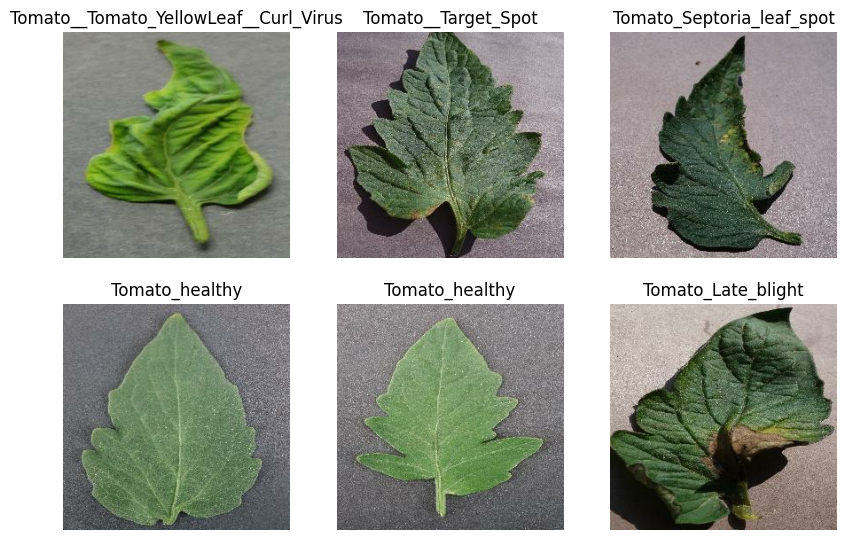

In [8]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(6):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

Split Dataset into:-> training,validation,testing

In [9]:
int(len(dataset)*0.8)

200

In [10]:
def get_dataset_partitions(ds,train_split=0.8,val_split=0.1,shuffle=True,shuffle_size=1000):
    n=len(ds)
    if(shuffle):
        ds.shuffle(shuffle_size,seed=12)

    train_size=int(n*train_split)
    val_size=int(n*val_split)

    train_ds=ds.take(train_size)
    test_ds=ds.skip(train_size)
    val_ds=test_ds.take(val_size)
    test_ds=test_ds.skip(val_size)

    return train_ds,val_ds,test_ds

In [11]:
train_ds,val_ds,test_ds=get_dataset_partitions(dataset)
len(train_ds),len(val_ds),len(test_ds)

(200, 25, 26)

Cache,Shuffle,Prefetch

In [12]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Resizing And Augmentation

In [13]:
resize_and_rescale=tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255)
])
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

Building Model

In [14]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=len(class_names)

model = keras.models.Sequential([
    resize_and_rescale,
    data_augmentation,
    
    keras.layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (64, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (64, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (64, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (64, 62, 62, 64)          0         
 g2D)                                                 

In [16]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [19]:
history=model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=1)

Epoch 1/30


200/200 [==============================] - 38s 192ms/step - loss: 1.1499 - accuracy: 0.6021 - val_loss: 1.4415 - val_accuracy: 0.5694
Epoch 2/30
200/200 [==============================] - 35s 174ms/step - loss: 0.8106 - accuracy: 0.7207 - val_loss: 1.1655 - val_accuracy: 0.6331
Epoch 3/30
200/200 [==============================] - 35s 174ms/step - loss: 0.6454 - accuracy: 0.7738 - val_loss: 1.2135 - val_accuracy: 0.6488
Epoch 4/30
200/200 [==============================] - 35s 173ms/step - loss: 0.5268 - accuracy: 0.8173 - val_loss: 1.1313 - val_accuracy: 0.6844
Epoch 5/30
200/200 [==============================] - 35s 173ms/step - loss: 0.4790 - accuracy: 0.8320 - val_loss: 1.0937 - val_accuracy: 0.6900
Epoch 6/30
200/200 [==============================] - 35s 174ms/step - loss: 0.4300 - accuracy: 0.8517 - val_loss: 0.6848 - val_accuracy: 0.7756
Epoch 7/30
200/200 [==============================] - 35s 173ms/step - loss: 0.3630 - accuracy: 0.8758 - val_loss: 0.7340 - val_accuracy: 0.7

In [20]:
model.evaluate(test_ds)

26/26 [==============================] - 7s 76ms/step - loss: 0.1864 - accuracy: 0.9441


[0.18641220033168793, 0.9441340565681458]

In [21]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 200}

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
history.history['accuracy'][:5]

[0.6021093726158142,
 0.720703125,
 0.7737500071525574,
 0.8173437714576721,
 0.83203125]

In [24]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

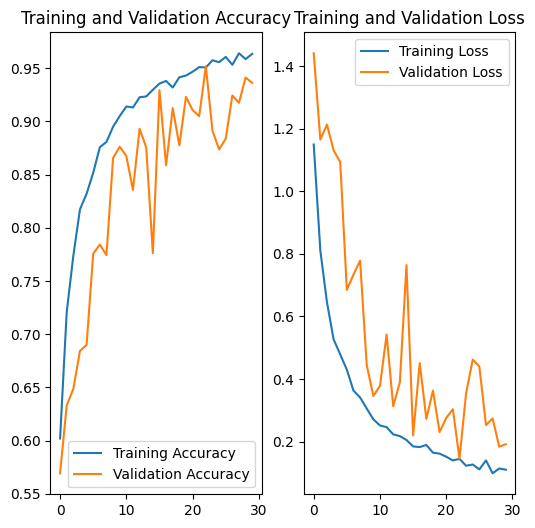

In [25]:
plt.figure(figsize=(6,6))
plt.subplot(1,2,1)

plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Running Predictions

In [27]:
def predict(model,img):
    #creating a batch from single image
    img_array=tf.keras.preprocessing.image.img_to_array(img)
    img_array=tf.expand_dims(img_array,0)

    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 15ms/step


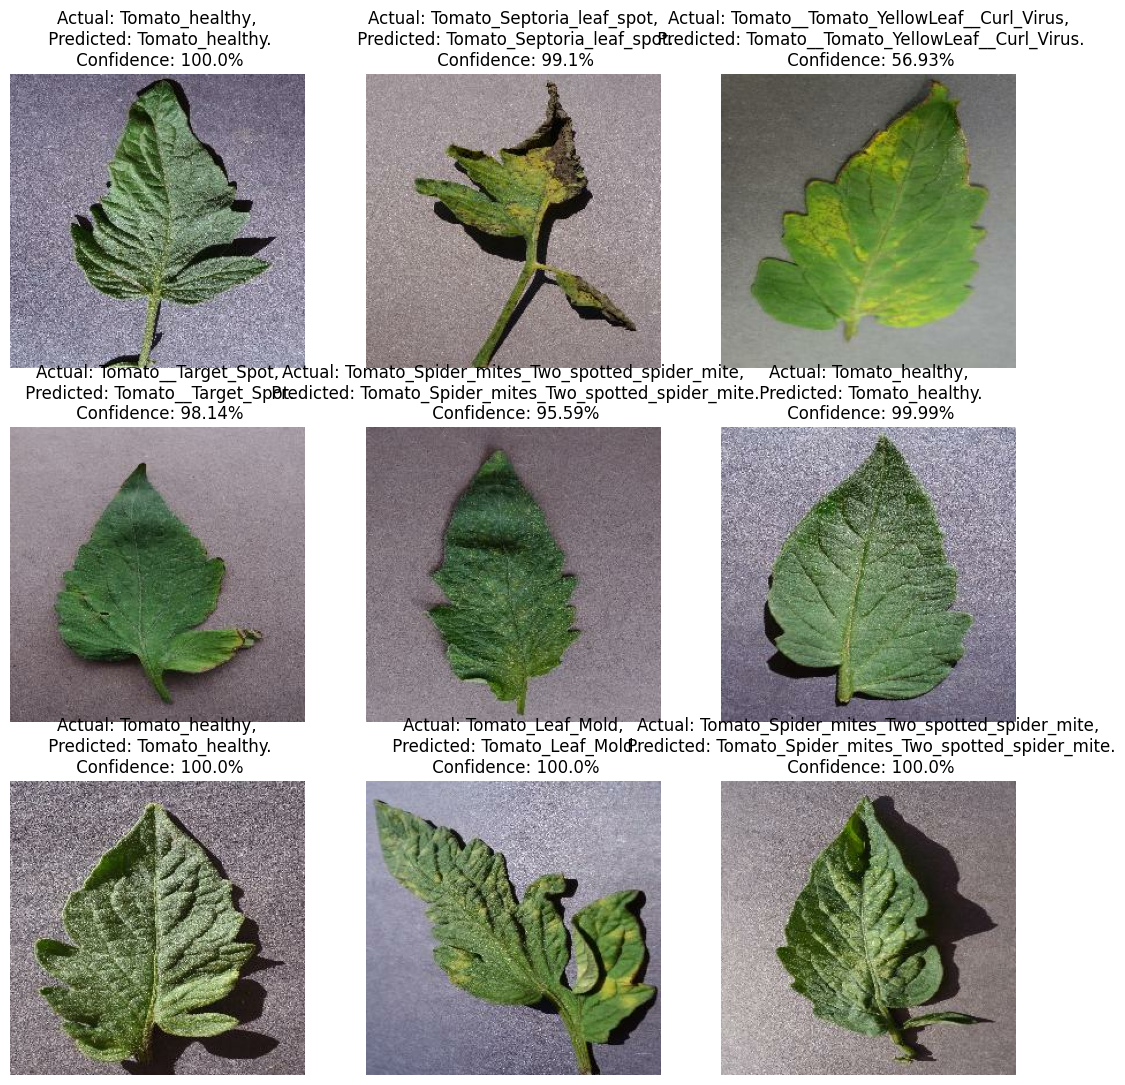

In [28]:
plt.figure(figsize=(13,13))
for image_batch,label_batch in dataset.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))

        predicted_class,confidence=predict(model,image_batch[i].numpy())
        actual_class=class_names[label_batch[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis('off')

Save the model

In [30]:
import os
model_version=max([int(i) for i in os.listdir("./models") + [0]])+1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/2/assets


INFO:tensorflow:Assets written to: ./models/2/assets
